# Case Study 1 - Predicting Superconductors 

__Team Members__

- Name 1: Amber Clark
- Name 2: Andrew Leppla
- Name 3: Jorge Olmos
- Name 4: Paritosh Rai

# Content
* [Business Understanding](#business-understanding)
* [Data Evaluation](#data-evaluation)
    - [Data Understanding](#data-understanding)
    - [Missing Values](#missing-values)
    - [Which Values are needed](#values-needed)
    - [Assumptions](#assumptions)
* [Model Preparations](#model-preparations)
    - [Method](#method)
    - [Evaluation Metrics](#evaluation-metrics)
* [Model Building & Evaluations](#model-building)
    - [Sampling Methodology](#sampling-methodology)
    - [L1 Model](#L1-model)
    - [L2 Model](#L2-model)
    - [Analysis](#analysis)
* [Model Interpretability & Explainability](#model-explanation)
* [Conclusion](#conclusion)

## Executive Summary

# Business Understanding <a id='business-understanding'/>



The primary purpose is to research is for the prediction of new superconductors and at the temperature at which they would occur based on the experimental data provided.

We have been provided with two files, once which lists the critical temperature at which the superconductor occurs and the properties associated to the superconductor. A second file maps the materials and breaks down the elements for each of the superconductors. 

Both files contains 21,263 records, with the training file and material files containing 88 variables, and 82 variables respectively. There are no duplicate records, however both the training and materials files contain a duplicate critical_temp column.

Our goal is to create models that predict the __critical temperature__, our target variable, for which a superconductor might occur. To do so we will be creating regression models (Ridge and Lasso), and utilizing different dimensionality reduction techniques to improve training time, avoid overfitting, and take care of multicollinearity. We will be using k-fold cross validation that will help our model have low bias, and evaluating our models using RMSE and an adjusted R^2.




# Data Evaluation <a id='data-evaluation'>
    

The data comes from a Japanese database, Materials Data Repository.  It is a database repository or materials research and publications.  The data we are working with has been used in a variety of analysis and publications available online conducting similar analysis to what we have done in our assignment

In [40]:
# standard libraries
import pandas as pd
import numpy as np
import time
import re #regex

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# data pre-processing
from sklearn.preprocessing import StandardScaler
#from sklearn import preprocessing

# prediction models
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
#from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLarsIC
from sklearn import metrics as mt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from kneed import KneeLocator
from scipy import stats

# import warnings filter
import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from tabulate import tabulate

## Loading Data

#### After loading data we noticed that all but three of the characteristics (number of elements, range of atomic mass of radius, range of valence) are floats

In [41]:
materials = pd.read_csv('superconduct/unique_m.csv') 
characteristics = pd.read_csv('superconduct/train.csv')

In [44]:
datadictionary = pd.read_csv('datadictionary.csv') 
col_names = ["Variable", "Description", "Type"]
print(tabulate(datadictionary, headers=col_names, tablefmt='fancy_grid'))

╒════╤═════════════════════════════════╤══════════════════════════════════════════════════════╤═════════╕
│    │ Variable                        │ Description                                          │ Type    │
╞════╪═════════════════════════════════╪══════════════════════════════════════════════════════╪═════════╡
│  0 │ number_of_elements              │ number of elements                                   │ Integer │
├────┼─────────────────────────────────┼──────────────────────────────────────────────────────┼─────────┤
│  1 │ mean_atomic_mass                │ mean of atomic mass                                  │ Float   │
├────┼─────────────────────────────────┼──────────────────────────────────────────────────────┼─────────┤
│  2 │ wtd_mean_atomic_mass            │ weighted mean of atomic mass                         │ Float   │
├────┼─────────────────────────────────┼──────────────────────────────────────────────────────┼─────────┤
│  3 │ gmean_atomic_mass               │ geome

## Missing Data

We looked at both the materials datasets and the train dataset and there appears to not be any missing values

In [20]:
materials.isnull().values.any()

False

In [22]:
characteristics.isnull().values.any()

False

## Exploring Correlations of Features 

We examined the correlations the pair correlations of features, and decided to remove the following three as they made it the final model, yet did not improve the overall perfomance. 

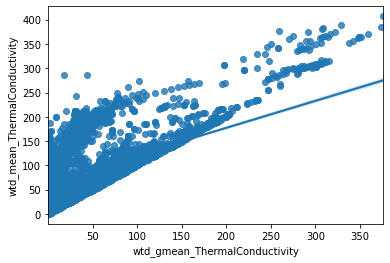

In [23]:
sns.regplot(y='wtd_mean_ThermalConductivity', x='wtd_gmean_ThermalConductivity', data=characteristics);


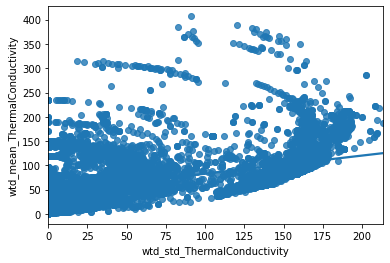

In [24]:
sns.regplot(y='wtd_mean_ThermalConductivity', x='wtd_std_ThermalConductivity', data=characteristics);

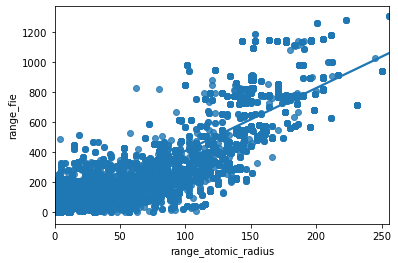

In [25]:
sns.regplot(x='range_atomic_radius', y='range_fie', data=characteristics);

### Which variables are needed (which ones are not)? 

We removed 9 elements (He', 'Ne', 'Ar', 'Kr', 'Xe', 'Pm', 'Po', 'At', 'Rn') that were not present in any of the materials we examined, therefore they will not contribute to the model. We speculate that the reason for these elements not showing up in any of the materials is that they're noble gases and don't have the propensity to react with any other elements. We additionally removed three characterics ('wtd_gmean_ThermalConductivity', 'wtd_std_ThermalConductivity','range_fie') from our features that were indentified from the multicollinearity analysis and instead kept the features that had higher correlations with the critical temperature.

In [26]:
describe =  materials.describe()
cols = describe.columns
material_drops = [c for c in cols if describe[c]['max'] == 0.0]
characteristic_drops = ['wtd_gmean_ThermalConductivity', 'wtd_std_ThermalConductivity','range_fie']
print("Material Drops", material_drops)
print("Characteristics ", characteristic_drops)

Material Drops ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Pm', 'Po', 'At', 'Rn']
Characteristics  ['wtd_gmean_ThermalConductivity', 'wtd_std_ThermalConductivity', 'range_fie']


In [27]:
materials = materials.drop(material_drops, axis = 1)
characteristics = train.drop(characteristic_drops, axis = 1)

##### cleaning up files before combining, critical temp (duplicated in characteristics) and material (unneeded) from materials

In [29]:
materials = materials.drop(['critical_temp', 'material'], axis = 1)

#### Combining Datasets

In [32]:
df = pd.concat([materials, characteristics ], axis=1)

## Determining Outliers and Removing Outliers

###### add an explanation

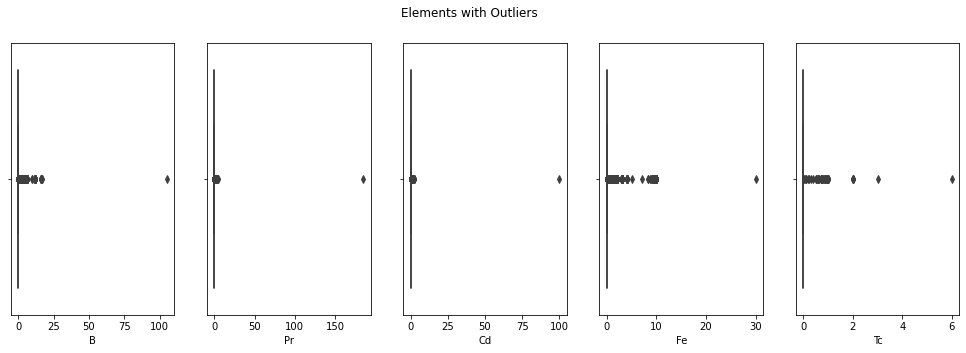

In [34]:
fig, axes = plt.subplots(1, 5, figsize=(17, 5))
fig.suptitle('Elements with Outliers')
outlier_elem = ['B', 'Pr', 'Cd', 'Fe', 'Tc']
for i,j in zip(outlier_elem, range(5)):
    sns.boxplot(ax = axes[j], x = materials[i]); 

In [249]:

df = df[ df['B'] < df['B'].max() ]
df = df[ df['Pr'] < df['Pr'].max() ]
df = df[ df['Cd'] < df['Cd'].max() ]
df = df[ df['Fe'] < df['Fe'].max() ]
df = df[ df['Tc'] < df['Tc'].max() ]
df = df[ df.index != 5918] # outlier in log transform models
print(df.shape)

(21257, 159)


## Examining Distribution of Target Variable: Critical Temperature

###### Even though is skewed our sample size is large enough (CLT),  We notice the data is bimodal which could indicate that there are different relationships for high temperature superconductors and regular superconductors (does not represent 1 population) , make data interprattion more dificult

(check the residuals for normality)

### Distribution of critical temperature 

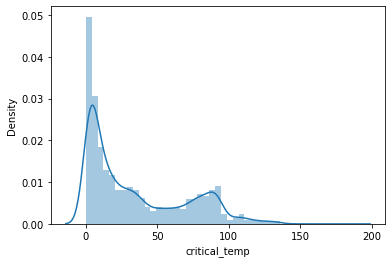

In [190]:
sns.distplot(df['critical_temp']);

### Distribution of log of critical temperature

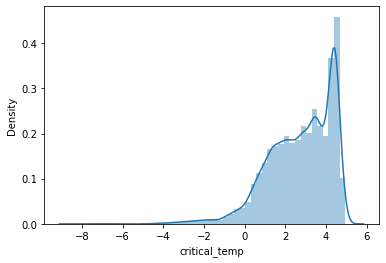

In [68]:
sns.distplot(np.log(df['critical_temp']));

# Skew Of Data

In [250]:
#for i in train.skew(axis=0):
#    print(i)
    #if i > 1:
    #    print(i) 
    
df_skew = train.skew()
df_skew.shape
df_skew.head()
df_skew.loc['wtd_mean_atomic_mass']
transformed_data = train

for col in train.columns:
    if abs(df_skew.loc[col]) > 1:
        print(abs(df_skew.loc[col]),col)
        transformed_data[col]= np.log(train[col])

#df_skew_2 = transformed_data.skew()        
# for col in train.columns:
#     if abs(df.loc[col]) > 1:
#         print(abs(df.loc[col]), print(col))

1.5039066527525764 wtd_mean_atomic_mass
1.474815716460679 gmean_atomic_mass
1.6982799470264731 wtd_gmean_atomic_mass
2.4638078639298486 wtd_range_atomic_mass
1.009764280457501 mean_fie
1.1919286264562294 gmean_fie
1.643162460903729 wtd_range_atomic_radius
2.103343841114579 mean_Density
2.1377633652220895 wtd_mean_Density
1.6591282559918128 gmean_Density
1.6509298548729716 wtd_gmean_Density
3.322725556824231 wtd_range_Density
1.098437437881419 mean_ElectronAffinity
1.3497357705423987 gmean_ElectronAffinity
2.5227818804703905 mean_FusionHeat
2.7638258028710343 wtd_mean_FusionHeat
2.665477197882816 gmean_FusionHeat
2.4875423104652383 wtd_gmean_FusionHeat
2.7485818063583047 range_FusionHeat
4.233613879127433 wtd_range_FusionHeat
2.822554806107452 std_FusionHeat
2.850133800691453 wtd_std_FusionHeat
1.379703282816514 wtd_mean_ThermalConductivity
2.3399514687914174 gmean_ThermalConductivity
2.588304794394417 wtd_gmean_ThermalConductivity
1.4159181865406276 wtd_range_ThermalConductivity
1.0036

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Scaling Data

In [251]:
# Define y and X
y = np.array( df['critical_temp'] )
df = df.drop(['critical_temp'], axis =1)
X = df

In [252]:
X

,H,Li,Be,B,C,N,O,F,Na,Mg,...,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence
0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.25,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.00,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606
2,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.25,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.25,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952
4,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,2.25,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.25,3.555556,3.223710,3.519911,1.377820,0.913658,1,2.168889,0.433013,0.496904
21259,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,...,2.20,2.047619,2.168944,2.038991,1.594167,1.337246,1,0.904762,0.400000,0.212959
21260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.50,4.800000,4.472136,4.781762,0.686962,0.450561,1,3.200000,0.500000,0.400000
21261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.50,4.690000,4.472136,4.665819,0.686962,0.577601,1,2.210000,0.500000,0.462493


### Using Standard Scaler to scale train data.

In [450]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234321) 

# Center and Scale X
scl = StandardScaler()
scl.fit(X_train)
X_train_scaled = scl.transform(X_train) # apply to training
X_test_scaled = scl.transform(X_test) # apply to the test set (without snooping)

In [451]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X.columns, index = X_test.index)

In [255]:
df_skew = X_train.skew()
for col in df.columns:
    if abs(df_skew.loc[col]) > 1:
        print(abs(df_skew.loc[col]),col)

31.689734812561447 H
12.605882163926495 Li
26.808560830664664 Be
10.264164541356006 B
13.82927222629775 C
39.54810634601638 N
2.3135159331331274 O
15.292262094888134 F
16.991197931169054 Na
27.38704786813435 Mg
49.970256138580375 Al
20.690704847817397 Si
29.77833400566718 P
9.273881656879954 S
15.189734071091683 Cl
14.024581891080787 K
7.744332363966371 Ca
24.415415372385457 Sc
24.110146812184436 Ti
19.288937640187253 V
34.69494907649359 Cr
87.02742766434173 Mn
9.548531864066828 Fe
43.98806437282861 Co
30.831996308669435 Ni
13.728567111339535 Cu
50.08019040265648 Zn
20.813657019620933 Ga
21.71062279266816 Ge
13.89881156236352 As
15.64707545122162 Se
28.35119277760651 Br
20.784662283815354 Rb
3.3488642633840255 Sr
4.44879370724173 Y
15.27260859262466 Zr
15.32536658931788 Nb
36.3827789945037 Mo
29.699146171093243 Tc
39.597678562247346 Ru
37.07117586367794 Rh
29.553316228030315 Pd
32.862276402415894 Ag
18.612053140464585 Cd
16.45766899530737 In
38.69979368947147 Sn
27.99971288730479 Sb
81

## Assumptions

### Target Variable interpretation

According to our research, the Kelvin temperature scale is used for temperature instead of Fahrenheit or Celsius in semiconductor research and manufacturing.  Scientists and engineers use the Kelvin scale because it is a temperature scale where the value zero reflects the complete absence of thermal energy.  The Kelvin scale does not have negative temperatures since 0 degrees kelvin is the lowest temperature.  Because negative temperatures do not exist on the Kelvin scale, in our modeling, we replaced negative predicted values with 0.

## Move up to EDA
## Variable Correlations with Critical Temp & Outliers

In [88]:
print(train[train.columns[1:]].corr()['critical_temp'][:-1].sort_values())

wtd_mean_Valence              -0.632401
wtd_gmean_Valence             -0.615653
mean_Valence                  -0.600085
gmean_Valence                 -0.573068
gmean_Density                 -0.541684
                                 ...   
wtd_entropy_atomic_mass        0.626930
std_ThermalConductivity        0.653632
range_atomic_radius            0.653759
range_ThermalConductivity      0.687654
wtd_std_ThermalConductivity    0.721271
Name: critical_temp, Length: 80, dtype: float64


In [112]:
outliers = pd.DataFrame()
for col in train.columns:
    col_zscore = col + "_zscore"
    outliers[col_zscore] = (train[col] - train[col].mean())/train[col].std(ddof=0)
outliers.head()

,number_of_elements_zscore,mean_atomic_mass_zscore,wtd_mean_atomic_mass_zscore,gmean_atomic_mass_zscore,wtd_gmean_atomic_mass_zscore,entropy_atomic_mass_zscore,wtd_entropy_atomic_mass_zscore,range_atomic_mass_zscore,wtd_range_atomic_mass_zscore,std_atomic_mass_zscore,...,wtd_mean_Valence_zscore,gmean_Valence_zscore,wtd_gmean_Valence_zscore,entropy_Valence_zscore,wtd_entropy_Valence_zscore,range_Valence_zscore,wtd_range_Valence_zscore,std_Valence_zscore,wtd_std_Valence_zscore,critical_temp_zscore
0,-0.080058,0.046733,-0.451651,-0.158850,-0.611819,0.044358,-0.003707,0.133725,-0.053039,0.378186,...,-0.752156,-0.805912,-0.711705,0.186292,0.035183,-0.837959,-0.406166,-0.838372,-0.520070,-0.158267
1,0.614744,0.174269,-0.432071,0.059368,-0.604180,0.777430,-0.015267,0.133725,0.108900,0.134901,...,-0.752156,-1.116731,-0.719454,0.664971,-0.014779,-0.033011,-0.362352,-0.426866,-0.450821,-0.245849
2,-0.080058,0.046733,-0.450978,-0.158850,-0.611658,0.044358,-0.218984,0.133725,0.093294,0.378186,...,-0.740164,-0.805912,-0.700728,0.186292,-0.062235,-0.837959,-0.376957,-0.838372,-0.503304,-0.450208
3,-0.080058,0.046733,-0.451314,-0.158850,-0.611739,0.044358,-0.103615,0.133725,0.020128,0.378186,...,-0.746160,-0.805912,-0.706224,0.186292,-0.010538,-0.837959,-0.391562,-0.838372,-0.511524,-0.362626
4,-0.080058,0.046733,-0.452324,-0.158850,-0.611980,0.044358,0.162775,0.133725,-0.199372,0.378186,...,-0.764149,-0.805912,-0.722618,0.186292,0.113627,-0.837959,-0.435376,-0.838372,-0.538178,-0.333432


## Add "Naive" Linear Model with all terms as our baseline model

## Feature Selection
### Add description

In [636]:
Lasso_df = []
L1 = Lasso()

for i in np.linspace(0.2, 5, 101):
    L1.alpha = i
  
    # Cross validation on training set
    L1_CV = cross_validate(L1, X_train_scaled, y_train, cv = 5, scoring=['neg_root_mean_squared_error','r2'])
    L1_CV_RMSE = round(np.mean(-L1_CV['test_neg_root_mean_squared_error']), 3)
    L1_CV_Rsq = round(np.mean(L1_CV['test_r2']), 4)
    
    L1.fit(X_train_scaled, y_train)
    num_terms = len(L1.coef_[L1.coef_!=0])
    
    Lasso_df.append([ L1.alpha, num_terms, L1_CV_RMSE, L1_CV_Rsq ])
    
Lasso_df = pd.DataFrame(Lasso_df, columns = ['Lasso alpha', '# Terms', 'CV RMSE', 'CV R-squared'])
Lasso_df

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1648040.457315056, tolerance: 1404.3101521253202
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator

,Lasso alpha,# Terms,CV RMSE,CV R-squared
0,0.00,158,16.890,0.7581
1,0.05,115,17.249,0.7476
2,0.10,95,17.556,0.7385
3,0.15,82,17.684,0.7347
4,0.20,74,17.805,0.7310
...,...,...,...,...
96,4.80,9,21.997,0.5898
97,4.85,9,22.024,0.5888
98,4.90,9,22.052,0.5878
99,4.95,9,22.080,0.5867


## Add explanation of Knee and why we chose the inflection point for model selection

In [637]:
kn1 = KneeLocator(Lasso_df['CV RMSE'], Lasso_df['# Terms'], curve='convex', direction='decreasing')
print('CV RMSE', kn.knee)

18.214


In [638]:
kn2 = KneeLocator(Lasso_df['CV R-squared'],  Lasso_df['# Terms'], curve='convex', direction='increasing')
print('CV R-squared', kn2.knee)

0.6942


In [639]:
kn3 = KneeLocator(Lasso_df['Lasso alpha'],Lasso_df['CV RMSE'], curve='concave', direction='increasing')
print('Lasso alpha', kn3.knee)

0.9


In [640]:
kn4 = KneeLocator(Lasso_df['Lasso alpha'],Lasso_df['CV R-squared'], curve='convex', direction='decreasing')
print('Lasso alpha', kn4.knee)

0.8500000000000001


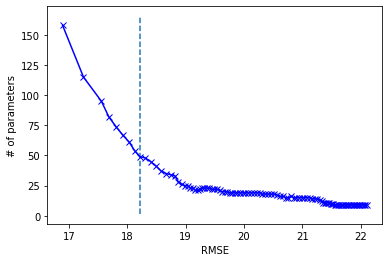

In [641]:
# Plot number of parameters vs. RMSE

plt.xlabel('RMSE')
plt.ylabel('# of parameters')
plt.plot(Lasso_df['CV RMSE'], Lasso_df['# Terms'], 'bx-')
plt.vlines(kn1.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

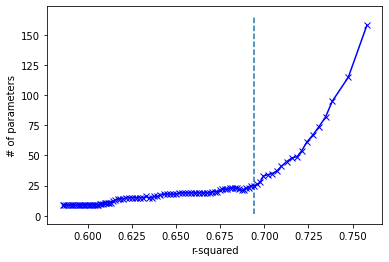

In [642]:
import matplotlib.pyplot as plt
plt.xlabel('r-squared')
plt.ylabel('# of parameters')
plt.plot(Lasso_df['CV R-squared'], Lasso_df['# Terms'], 'bx-')
plt.vlines(kn2.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

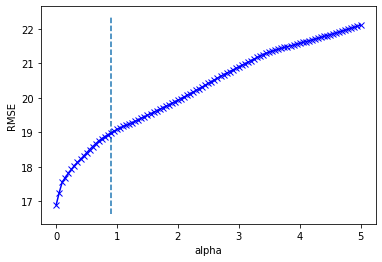

In [643]:
import matplotlib.pyplot as plt
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.plot(Lasso_df['Lasso alpha'],Lasso_df['CV RMSE'], 'bx-')
plt.vlines(kn3.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

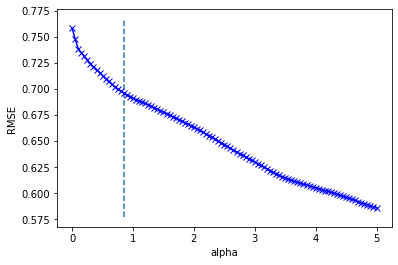

In [644]:
import matplotlib.pyplot as plt
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.plot(Lasso_df['Lasso alpha'],Lasso_df['CV R-squared'], 'bx-')
plt.vlines(kn4.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

In [598]:
Lasso_df['CV R-squared']

0      0.7310
1      0.7304
2      0.7298
3      0.7292
4      0.7285
        ...  
196    0.6642
197    0.6639
198    0.6637
199    0.6634
200    0.6631
Name: CV R-squared, Length: 201, dtype: float64

# Model Preparations <a id='model-preparations'>

### Which methods are you proposing to utilize to solve the problem?  

### Why is this method appropriate given the business objective?

### How will you determine if your approach is useful (or how will you differentiate which approach is more useful than another)?  More specifically, what evaluation metrics are most useful given that the problem is a regression one (ex., RMSE, logloss, MAE, etc.)?

Talk baout r-squared, rmse and multicollinearity

## Select model terms with Lasso

In order reduce the number of parameters we wanted to find the point at which rmse and r^2 begins to flatten after  each additional paramater is added. This is the point of dimishing returns. Depending on what measurement is maximized we can return diffent values for penalizing the model (alpha). Based on our modeling we believe the point of dimishing returns to maximize the r^2 is alpha=0.9. The point of diminishing returns for RMSE is an alpha of 0.85.

In [742]:
L1 = Lasso(alpha = .9)
L1.fit(X_train_scaled, y_train)

y_hat_train = L1.predict(X_train_scaled)
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Lasso Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Lasso Training R-Sq =", round(Rsq,3) )

y_hat_test = L1.predict(X_test_scaled)
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLasso Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Lasso Test R-Sq =", round(Rsq,3) )

model_coef = pd.DataFrame(zip(X.columns, L1.coef_), columns=['Factor','Coef'])
model_factors = model_coef[model_coef['Coef']!=0]

print("\nKept Factors(", model_factors.shape[0], "of", X.shape[1],"):")
model_coef[model_coef['Coef']!=0].sort_values(by='Coef')

Lasso Training RMSE = 18.87
Lasso Training R-Sq = 0.698

Lasso Test RMSE = 18.44
Lasso Test R-Sq = 0.706

Kept Factors( 25 of 158 ):


,Factor,Coef
157,wtd_std_Valence,-3.551243
121,wtd_gmean_ElectronAffinity,-3.256133
11,Si,-2.542338
110,gmean_Density,-1.791377
53,Pr,-1.664248
141,wtd_gmean_ThermalConductivity,-1.336341
29,As,-0.801547
137,wtd_std_FusionHeat,-0.710089
52,Ce,-0.656177
54,Nd,-0.464878


In [745]:
# Set any negative predictions to 0 and reassess performance.  
# Cannot have negative degrees Kelvin as mentioned previously in the Assumptions section. 

y_hat_train[y_hat_train<0]=0
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "\nLinReg Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "LinReg Training R-Sq =", round(Rsq,3) )

y_hat_test[y_hat_test<0]=0
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nLinReg Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "LinReg Test R-Sq =", round(Rsq,3) )


LinReg Training RMSE = 18.77
LinReg Training R-Sq = 0.702

LinReg Test RMSE = 18.36
LinReg Test R-Sq = 0.709


# Model Building & Evaluations <a id='#model-building'>

### Specify your sampling methodology

### Setup your model(s) 
## Final Ridge Model Built from Lasso Model Selection -- Setup your model(s) 

Describe model
specifying the regularization type chosen and including the parameters utilized by the model


In [749]:
L2 = Ridge(alpha = 100)
model_terms = list(model_factors['Factor'])
L2.fit(X_train_scaled[model_terms], y_train)

y_hat_train = L2.predict(X_train_scaled[model_terms])
y_hat_train[y_hat_train<0]=0
RMSE = round(mse(y_train, y_hat_train, squared=False), 2)
print( "Ridge Training RMSE =", round(RMSE,2) )
Rsq = r2_score(y_train, y_hat_train)
print( "Ridge Training R-Sq =", round(Rsq,3) )

y_hat_test = L2.predict(X_test_scaled[model_terms])
y_hat_test[y_hat_test<0]=0
RMSE = round(mse(y_test, y_hat_test, squared=False), 2)
print( "\nRidge Test RMSE =", round(RMSE,2) )
Rsq = r2_score(y_test, y_hat_test)
print( "Ridge Test R-Sq =", round(Rsq,3) )

model_coef1 = pd.DataFrame(zip(X[model_terms].columns, L2.coef_), columns=['Factor','Coef'])
model_factors1 = model_coef[model_coef['Coef']!=0]

print("\nKept Factors(", model_factors1.shape[0], "of", X.shape[1],"):")
model_coef1[model_coef1['Coef']!=0].sort_values(by=['Coef'])

Ridge Training RMSE = 18.55
Ridge Training R-Sq = 0.708

Ridge Test RMSE = 18.09
Ridge Test R-Sq = 0.717

Kept Factors( 25 of 158 ):


,Factor,Coef
21,wtd_std_Valence,-5.490780
0,Si,-4.098103
17,gmean_Density,-3.781179
18,wtd_gmean_ElectronAffinity,-3.073510
19,wtd_std_FusionHeat,-3.021639
3,As,-2.511130
8,Pr,-2.277496
7,Ce,-1.264847
2,Ge,-1.197090
9,Nd,-1.140194


In [750]:
model_coef1['abs_Coef'] = abs(model_coef1['Coef'])
model_coef1.sort_values(by=['abs_Coef'])

#### Add comment about removing gmean thermalconductivity

### Analyze your model's performance - referencing your chosen evaluation metric (including supplemental visuals and analysis where appropriate)

# Model Interpretability & Explainability <a id='model-explanation'>

## Which variable(s) was (were) "most important" and why?

## How did you come to the conclusion and how should your audience interpret this?

# Conclusion <a id='conclusion'>
    


The goal of our analysis was to predict the critical temperature for superconductors.  Determining the critical temperature is important because if superconductors don't cool down below a certain temperature, they lose their conductivity.  The team built a linear model after using LASSO select features. 

### After all of your technical analysis and modeling; what are you proposing to your audience and why? 

We're proposing a linear regression model with L1 and L2 regularization, to reduce the number of features and prevent overfitting, that predicts the critical temperatures using 9 material characteristics and 13 elements out of the 158 total features (81 materical characteristics and 77 elements) provided. Our model achieved and r-squared of 0.72 and an RMSE of 18 degrees K. One of our primary goals was to achieve high model interpretability and reduce the model complexity while at the same time minimizing impact on model performance.  


### How should they view your results and what should they consider when moving forward? 

Attempt to build two separate models for low and high temperature superconductors. We noticed that our observations might come from two separate populations since distribution appears to be bimodal. This in turn would reduce the rmse of each model.


### Are there other approaches you'd recommend exploring?  This is where you "bring it all home" in language they understand.
